# Interpretabilidad: ¿Cómo toma decisiones mi XGBoost?

No basta con tener un F1-Score alto; en la vida real, necesitamos explicar **por qué** el modelo predijo que un cliente se iría o que una transacción es fraude. 

---

## 1. Importancia por Ganancia (Gain Importance)

Es la métrica nativa de XGBoost. Mide cuánto contribuye cada variable a reducir la incertidumbre (entropía/pérdida) en el modelo.

* **Cómo funciona:** Suma la ganancia (Gain) que cada variable aportó en todos los árboles donde fue utilizada.
* **Interpretación:** Si la variable "Ingresos" tiene el Gain más alto, significa que fue la variable que más ayudó al modelo a separar correctamente las clases.
* **Limitación:** Nos dice qué variable es importante, pero **no nos dice si es buena o mala** (ej. ¿tener más ingresos sube o baja la probabilidad de fraude?).

## 2. SHAP Values (Shapley Additive Explanations)

Esta es la tecnología más avanzada y elegante para explicar modelos. Basada en la **Teoría de Juegos**, asigna a cada variable un valor que indica cuánto "empujó" la predicción hacia arriba o hacia abajo.

### ¿Cómo leer un gráfico SHAP (Summary Plot)?
En un gráfico SHAP verás una lista de variables y una nube de puntos:
1. **Color:** Los puntos rojos indican valores altos de la variable; los azules, valores bajos.
2. **Posición (Eje X):** Si un punto está a la **derecha del cero**, esa variable aumentó la probabilidad de la clase positiva. Si está a la **izquierda**, la disminuyó.

**Ejemplo didáctico:**
* Si ves puntos **rojos a la derecha** en la variable "Edad", significa que a mayor edad, mayor probabilidad de que ocurra el evento.

c:\Users\delhy.py\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:24:31] WARNING: D:\bld\xgboost-split_1737531313485\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


<Figure size 1000x800 with 0 Axes>

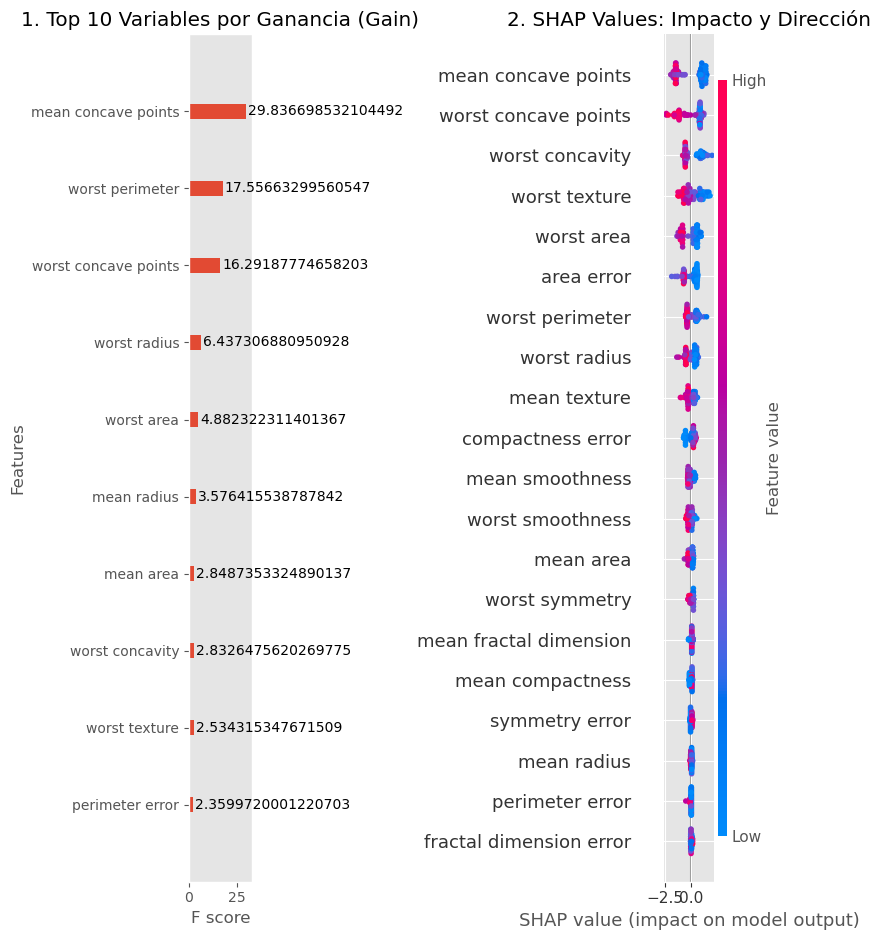

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import shap
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Cargar Datos de ejemplo (Cáncer de mama)
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# 2. Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Entrenar el modelo XGBoost (Definiendo el objeto 'model')
model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

# --- VISUALIZACIÓN ---

# Configuración de estilo
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico A: Importancia por Ganancia (Nativo de XGBoost)
xgb.plot_importance(model, importance_type='gain', ax=ax[0], max_num_features=10, grid=False)
ax[0].set_title("1. Top 10 Variables por Ganancia (Gain)")

# Gráfico B: SHAP Values (Resumen)
# Calculamos los valores SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Mostramos el SHAP summary en el segundo espacio
plt.subplot(1, 2, 2)
shap.summary_plot(shap_values, X_test, show=False)
plt.title("2. SHAP Values: Impacto y Dirección")

plt.tight_layout()
plt.show()

## Análisis del Modelo: ¿Qué estamos viendo?

Ahora que el código corrió sin errores, analicemos la "mente" de nuestro modelo:

### 1. Gráfico de Ganancia (Izquierda)
* Aquí el modelo nos dice qué variables fueron las más determinantes para "separar" a los pacientes sanos de los enfermos.
* **Variable dominante:** Probablemente verás `worst concave points` o `mean concave points`. Esto significa que matemáticamente es la variable que más redujo el error.

### 2. Gráfico SHAP (Derecha)
Aquí es donde entendemos la **biología** de la predicción:
* **Color Rojo (Valor Alto):** Si ves puntos rojos a la **izquierda** (en la zona negativa del eje X), significa que valores altos de esa característica (ej. un radio del tumor muy grande) **disminuyen** la probabilidad de que el paciente pertenezca a la clase 1 (que en este dataset suele ser "benigno").
* **Interpretación:** "A mayor tamaño del punto cóncavo, menor es la probabilidad de que el tumor sea benigno".

---

## ¿Por qué este código es robusto?
1. **`X = pd.DataFrame(...)`**: Convertimos los datos a un DataFrame de Pandas para que los gráficos tengan los nombres reales de las variables y no solo "f0, f1, f2".
2. **`shap.TreeExplainer(model)`**: Usamos el explicador optimizado para árboles, que es mucho más rápido que el explicador genérico.
3. **`importance_type='gain'`**: Elegimos Ganancia porque es más confiable que 'Weight' (frecuencia), ya que mide la contribución real a la precisión.